In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import các thư viện cần thiết
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from google.colab import drive

In [ ]:
# Đường dẫn tới dataset trên Google Drive
dataset_path = '/content/drive/MyDrive/Project_01/Dataset_BUSI_with_GT/'

In [ ]:
# Kiểm tra cấu trúc thư mục và số lượng ảnh
print("Kiểm tra cấu trúc thư mục và số lượng ảnh:")
for folder in ['normal', 'benign', 'malignant']:
    path = os.path.join(dataset_path, folder)
    print(f"Số lượng ảnh trong thư mục {folder}: {len(os.listdir(path))}")


Kiểm tra cấu trúc thư mục và số lượng ảnh:
Số lượng ảnh trong thư mục normal: 266
Số lượng ảnh trong thư mục benign: 891
Số lượng ảnh trong thư mục malignant: 421


In [ ]:
# Thiết lập các tham số
IMG_SIZE = 224  # DenseNet yêu cầu kích thước input là 224x224
BATCH_SIZE = 16 # Batch size xác định số lượng ảnh được đưa vào mô hình cùng một lúc trong mỗi lần xử lý
EPOCHS = 30     #Số epoch chỉ số lần toàn bộ dữ liệu huấn luyện được đưa qua mô hình.
CLASSES = ['benign', 'malignant', 'normal']
NUM_CLASSES = len(CLASSES)

Chia dữ liệu ảnh thành 3 tập riêng biệt: tập huấn luyện (train), tập xác thực (validation) và tập kiểm tra (test)

In [ ]:
# Chia dataset thành tập train, validation và test
def split_data(dataset_path):
    data_paths = []
    labels = []

    for class_index, class_name in enumerate(CLASSES):
        class_path = os.path.join(dataset_path, class_name)
        for img_name in os.listdir(class_path):
            data_paths.append(os.path.join(class_path, img_name))
            labels.append(class_index)

    # Chia thành train (70%), validation (15%) và test (15%)
    X_train, X_temp, y_train, y_temp = train_test_split(data_paths, labels, test_size=0.3, random_state=42, stratify=labels)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(dataset_path)

print(f"Train set: {len(X_train)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")


Train set: 1104 images
Validation set: 237 images
Test set: 237 images


In [ ]:
# Kiểm tra phân phối dữ liệu sau khi chia
def count_class_distribution(labels):
    return np.bincount(labels)

print("Phân phối dữ liệu theo lớp:")
print(f"Train: {count_class_distribution(y_train)}")
print(f"Validation: {count_class_distribution(y_val)}")
print(f"Test: {count_class_distribution(y_test)}")

Phân phối dữ liệu theo lớp:
Train: [623 295 186]
Validation: [134  63  40]
Test: [134  63  40]


 Tiền xử lý cho từng ảnh đầu vào trước khi đưa vào mô hình.

In [ ]:
# Tạo các Data Generator với augmentation cho tập train và không augmentation cho tập validation/test
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển từ định dạng màu mặc định của OpenCV (BGR) sang RGB
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # Ảnh được resize về kích thước chuẩn (IMG_SIZE x IMG_SIZE)
    img = img / 255.0  # Chuẩn hóa pixel về khoảng [0,1]
    return img

Tạo dữ liệu huấn luyện với các phép biến đổi (augmentation) nhằm mở rộng tập dữ liệu và giúp mô hình học tốt hơn.

In [ ]:
# Data Generator cho tập train với data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,    #Cho phép xoay ảnh ngẫu nhiên trong khoảng ±20 độ.
    width_shift_range=0.2,  #Dịch chuyển ảnh theo chiều ngang và chiều dọc tới 20% kích thước ảnh, tạo ra các biến thể vị trí khác nhau.
    height_shift_range=0.2,
    shear_range=0.2,    #Áp dụng phép biến dạng hình học (shear) với cường độ lên tới 20%, giúp mô hình học được các biến thể hình dạng.
    zoom_range=0.2,   #Phóng to hoặc thu nhỏ ảnh ngẫu nhiên trong khoảng 20%, làm tăng sự đa dạng của các mức độ phóng đại.
    horizontal_flip=True, #Lật ảnh theo chiều ngang, tạo thêm các bản sao đối xứng của ảnh gốc.
    fill_mode='nearest' #Xác định phương pháp điền các pixel trống sau khi biến đổi, sử dụng giá trị pixel gần nhất.
)

 Cell code này định nghĩa một hàm tạo dữ liệu (data generator) dùng cho cả tập validation và test, cũng như cho tập huấn luyện có áp dụng data augmentation. Cho phép tạo ra các batch dữ liệu linh hoạt, xử lý ảnh và áp dụng data augmentation nếu cần, đảm bảo dữ liệu đầu vào được chuẩn bị đúng cho quá trình huấn luyện và đánh giá mô hình.

In [ ]:
# Data Generator cho tập validation/test không có augmentation
val_test_datagen = ImageDataGenerator()

def generate_data(data_paths, labels, batch_size, datagen, is_train=False):
    while True:
        batch_paths = []
        batch_labels = []

        for i in range(batch_size):
            index = np.random.randint(0, len(data_paths))
            batch_paths.append(data_paths[index])
            batch_labels.append(labels[index])

            if len(batch_paths) == batch_size:
                batch_images = np.array([preprocess_image(path) for path in batch_paths])
                batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, NUM_CLASSES)

                if is_train:
                    # Áp dụng augmentation cho từng ảnh trong batch
                    batch_augmented = np.zeros_like(batch_images)
                    for i, img in enumerate(batch_images):
                        batch_augmented[i] = datagen.random_transform(img)
                    yield batch_augmented, batch_labels_one_hot
                else:
                    yield batch_images, batch_labels_one_hot

                batch_paths = []
                batch_labels = []

train_generator = generate_data(X_train, y_train, BATCH_SIZE, train_datagen, is_train=True)
val_generator = generate_data(X_val, y_val, BATCH_SIZE, val_test_datagen)
test_generator = generate_data(X_test, y_test, BATCH_SIZE, val_test_datagen)


Xây dựng một mô hình transfer learning dựa trên DenseNet-201, có khả năng học và phân loại ảnh y khoa thành các lớp như benign, malignant và normal.

In [ ]:
# Xây dựng mô hình DenseNet-201 với transfer learning
def build_model():
    # Sử dụng DenseNet-201 pre-trained trên ImageNet, không bao gồm lớp fully connected
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

    # Thêm các lớp mới cho bài toán phân loại của chúng ta
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)  # Thêm dropout để tránh overfitting
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)  # Thêm dropout để tránh overfitting
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Đóng băng các lớp của mô hình cơ sở (transfer learning)
    for layer in base_model.layers:
        layer.trainable = False

    return model

In [ ]:
# Xây dựng mô hình ban đầu
model = build_model()

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tóm tắt kiến trúc mô hình
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 20,815,427 (79.40 MB)

 Trainable params: 2,493,443 (9.51 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
# Cài đặt callbacks
checkpoint_path = '/content/drive/MyDrive/project_01/breast_cancer_model/best_model.h5'  # Lưu mô hình tốt nhất
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

In [ ]:
# Tính số bước cho mỗi epoch
train_steps = len(X_train) // BATCH_SIZE
val_steps = len(X_val) // BATCH_SIZE
if len(X_train) % BATCH_SIZE != 0:
    train_steps += 1
if len(X_val) % BATCH_SIZE != 0:
    val_steps += 1

Giai đoạn 1: Huấn luyện lớp phân loại với các trọng số mô hình gốc được giữ nguyên để học các đặc trưng cơ bản.

Tránh phá vỡ các đặc trưng tổng quát đã học từ DenseNet.

Tập trung tối ưu lớp phân loại mới với dữ liệu ít (thường gặp trong y tế).


In [ ]:
# Giai đoạn 1: Huấn luyện lớp đầu ra với base model bị đóng băng
print("Giai đoạn 1: Huấn luyện các lớp thêm vào")
history_phase1 = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks
)

Giai đoạn 1: Huấn luyện các lớp thêm vào
Epoch 1/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5624 - loss: 0.9205
Epoch 1: val_accuracy improved from -inf to 0.78750, saving model to /content/drive/MyDrive/project_01/breast_cancer_model/best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 507s 6s/step - accuracy: 0.5638 - loss: 0.9185 - val_accuracy: 0.7875 - val_loss: 0.4613 - learning_rate: 1.0000e-04
Epoch 2/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7644 - loss: 0.5328
Epoch 2: val_accuracy improved from 0.78750 to 0.82500, saving model to /content/drive/MyDrive/project_01/breast_cancer_model/best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.7643 - loss: 0.5330 - val_accuracy: 0.8250 - val_loss: 0.4230 - learning_rate: 1.0000e-04
Epoch 3/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - accuracy: 0.7493 - loss: 0.5468
Epoch 3: val_accuracy did not improve from 0.82500
69/69 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7496 - loss: 0.5462 - val_accuracy: 0.7750 - val_loss: 0.4619 - learning_rate: 1.0000e-04
Epoch 4/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.7953 - loss: 0.4694
Epoch 4: val_accuracy did not improve from 0.82500
69/69 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.7952 - loss: 0.4692 - val_accuracy: 0.7792 - val_loss: 0.4464 - learning_rate: 1.0000e-04
Epoch 5/10
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.7896 - loss: 0.4802
Epoch 5: val_accuracy did not improve from 0.82500
69/69 ━━━━━━━━━━━━━━━━━━━━ 30s 446ms/step - accuracy: 0.7896 - loss: 0.4799 - val_accuracy: 0.7917 - val_loss: 0.4351 - learning_rate: 1.0000e-04
Epoch 6/10
69

Giai đoạn 2: Tinh chỉnh một số lớp cuối của mô hình gốc để điều chỉnh các đặc trưng cấp cao phù hợp hơn với dữ liệu ảnh y khoa.

Tinh chỉnh các đặc trưng mức cao từ mô hình nền để phù hợp với dữ liệu mục tiêu.

Learning rate thường nhỏ hơn giai đoạn 1 để tránh nhiễu trọng số.

In [ ]:
# Giai đoạn 2: Fine-tuning - Mở đóng băng một số lớp của base model
print("Giai đoạn 2: Fine-tuning các lớp cuối của DenseNet")
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense) or "conv5" in layer.name:
        layer.trainable = True


Giai đoạn 2: Fine-tuning các lớp cuối của DenseNet


In [ ]:
# Biên dịch lại mô hình với learning rate thấp hơn để fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Tiếp tục huấn luyện
history_phase2 = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=EPOCHS - 10,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=callbacks,
    initial_epoch=10
)

Epoch 11/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.7628 - loss: 0.6193
Epoch 11: val_accuracy did not improve from 0.82500
69/69 ━━━━━━━━━━━━━━━━━━━━ 164s 770ms/step - accuracy: 0.7629 - loss: 0.6187 - val_accuracy: 0.7458 - val_loss: 0.5429 - learning_rate: 1.0000e-05
Epoch 12/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7804 - loss: 0.5010
Epoch 12: val_accuracy did not improve from 0.82500
69/69 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.7803 - loss: 0.5008 - val_accuracy: 0.7500 - val_loss: 0.4925 - learning_rate: 1.0000e-05
Epoch 13/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7706 - loss: 0.5021
Epoch 13: val_accuracy did not improve from 0.82500
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 601ms/step - accuracy: 0.7707 - loss: 0.5020 - val_accuracy: 0.7792 - val_loss: 0.4837 - learning_rate: 1.0000e-05
Epoch 14/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.8146 - loss: 0.4215
Epoch 14: val_accuracy did not improve from 0.82500
69/69 ━━

69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 419ms/step - accuracy: 0.8464 - loss: 0.3808 - val_accuracy: 0.8333 - val_loss: 0.3769 - learning_rate: 1.0000e-05
Epoch 19/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.8602 - loss: 0.3650
Epoch 19: val_accuracy did not improve from 0.83333
69/69 ━━━━━━━━━━━━━━━━━━━━ 29s 421ms/step - accuracy: 0.8604 - loss: 0.3645 - val_accuracy: 0.8167 - val_loss: 0.4202 - learning_rate: 1.0000e-05
Epoch 20/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8706 - loss: 0.3129
Epoch 20: val_accuracy improved from 0.83333 to 0.84583, saving model to /content/drive/MyDrive/project_01/breast_cancer_model/best_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 47s 687ms/step - accuracy: 0.8706 - loss: 0.3130 - val_accuracy: 0.8458 - val_loss: 0.4331 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 20.


In [ ]:
# Kết hợp lịch sử huấn luyện của hai giai đoạn
history = {}
history['accuracy'] = history_phase1.history['accuracy'] + history_phase2.history['accuracy']
history['val_accuracy'] = history_phase1.history['val_accuracy'] + history_phase2.history['val_accuracy']
history['loss'] = history_phase1.history['loss'] + history_phase2.history['loss']
history['val_loss'] = history_phase1.history['val_loss'] + history_phase2.history['val_loss']


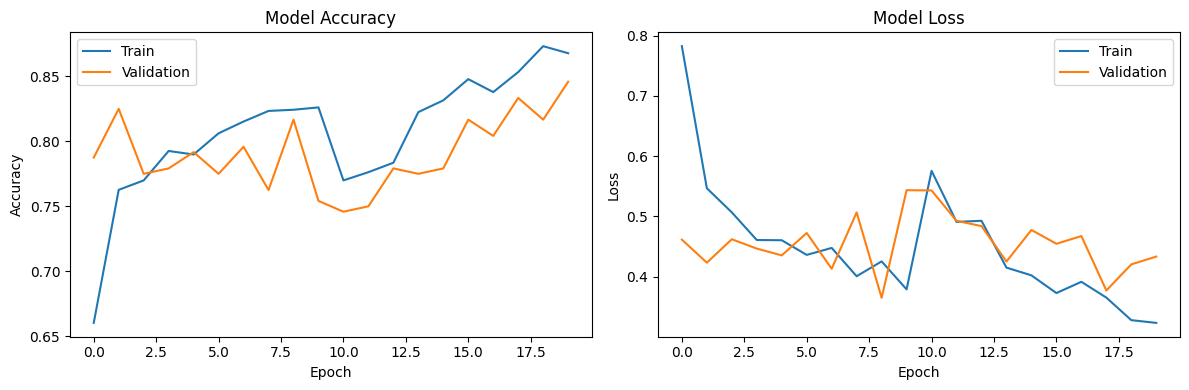

In [ ]:
# Vẽ biểu đồ kết quả huấn luyện
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
# Đánh giá mô hình trên tập test
def evaluate_model(model, X_test, y_test):
    y_pred_prob = []
    y_true = []

    for i in range(0, len(X_test), BATCH_SIZE):
        batch_paths = X_test[i:i+BATCH_SIZE]
        batch_images = np.array([preprocess_image(path) for path in batch_paths])
        batch_pred = model.predict(batch_images)
        y_pred_prob.extend(batch_pred)

        batch_labels = y_test[i:i+BATCH_SIZE]
        batch_labels_one_hot = tf.keras.utils.to_categorical(batch_labels, NUM_CLASSES)
        y_true.extend(batch_labels_one_hot)

    y_pred_prob = np.array(y_pred_prob)
    y_true = np.array(y_true)

    # Chuyển về nhãn dự đoán
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true_class = np.argmax(y_true, axis=1)

    # Tính toán các độ đo
    acc = accuracy_score(y_true_class, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Tính precision, recall, f1 cho từng lớp
    precision = precision_score(y_true_class, y_pred, average=None)
    recall = recall_score(y_true_class, y_pred, average=None)
    f1 = f1_score(y_true_class, y_pred, average=None)

    # In kết quả chi tiết
    print("\nPhân loại chi tiết:")
    for i, class_name in enumerate(CLASSES):
        print(f"{class_name}: Precision={precision[i]:.4f}, Recall={recall[i]:.4f}, F1-Score={f1[i]:.4f}")

    # In báo cáo phân loại
    print("\nBáo cáo phân loại:")
    print(classification_report(y_true_class, y_pred, target_names=CLASSES))

    # Vẽ confusion matrix
    cm = confusion_matrix(y_true_class, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    # Tính toán và vẽ đường cong ROC cho mỗi lớp
    plt.figure(figsize=(10, 8))

    for i, class_name in enumerate(CLASSES):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return acc, precision, recall, f1, cm, y_pred_prob



Đánh giá mô hình trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
Accuracy: 0.8819

Phân loại chi tiết:
benign: Precision=0.8857, Recall=0.9254, F1-Score=0.9051
malignant: Precision=0.8548, Recall=0.8413, F1-Score=0.8480
normal: Precision=0.9143, Recall=0.8000, F1-Score=0.8533

Báo cáo phân loại:
              precision    recall  f1-score   support

      benign       0.89      0.93      0.91       134
   malignant       0.85      0.84      0.85 

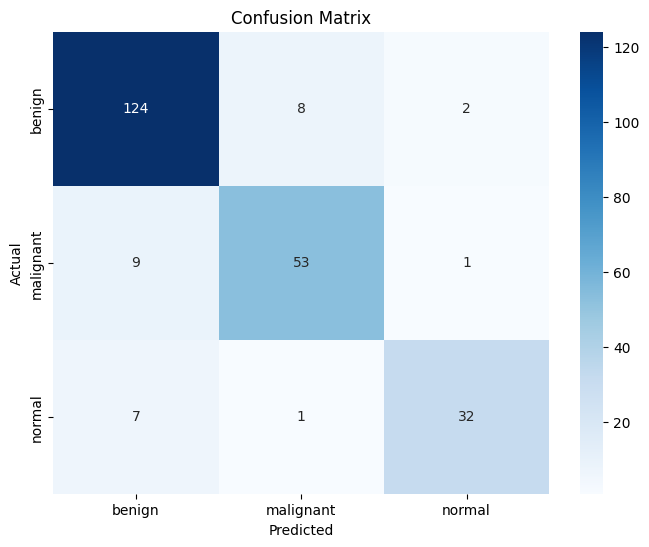

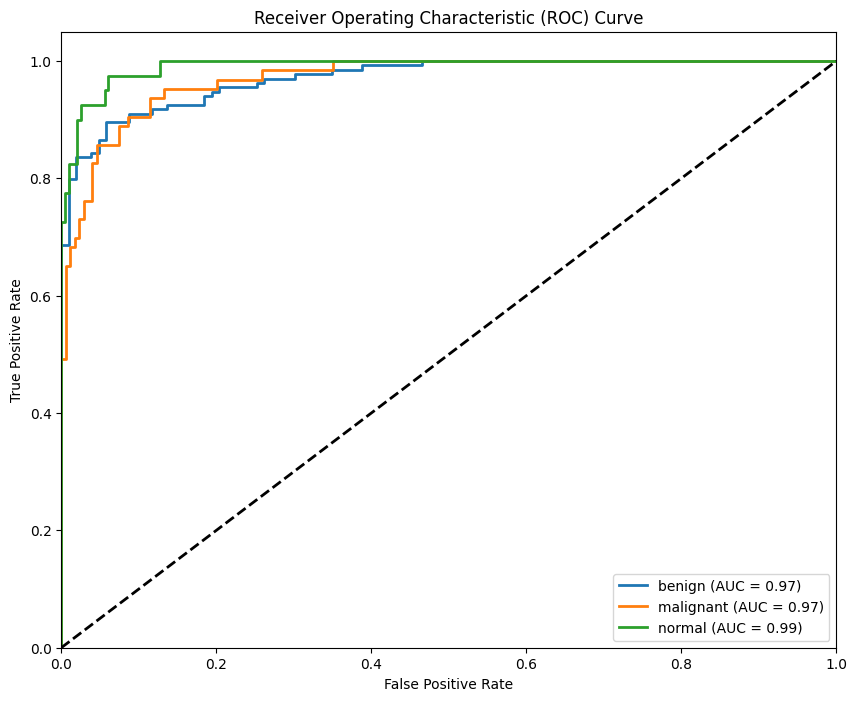

In [ ]:
# Đánh giá mô hình trên tập test
print("Đánh giá mô hình trên tập test:")
acc, precision, recall, f1, cm, y_pred_prob = evaluate_model(model, X_test, y_test)


In [ ]:
# Tải mô hình tốt nhất
best_model = load_model(checkpoint_path)


Đánh giá mô hình tốt nhất trên tập test:
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
Accuracy: 0.8819

Phân loại chi tiết:
benign: Precision=0.8857, Recall=0.9254, F1-Score=0.9051
malignant: Precision=0.8548, Recall=0.8413, F1-Score=0.8480
normal: Precision=0.9143, Recall=0.8000, F1-Score=0.8533

Báo cáo phân loại:
              precision    recall  f1-score   support

      benign       0.89      0.93      0.91       134
   malignant       0.85      0.84 

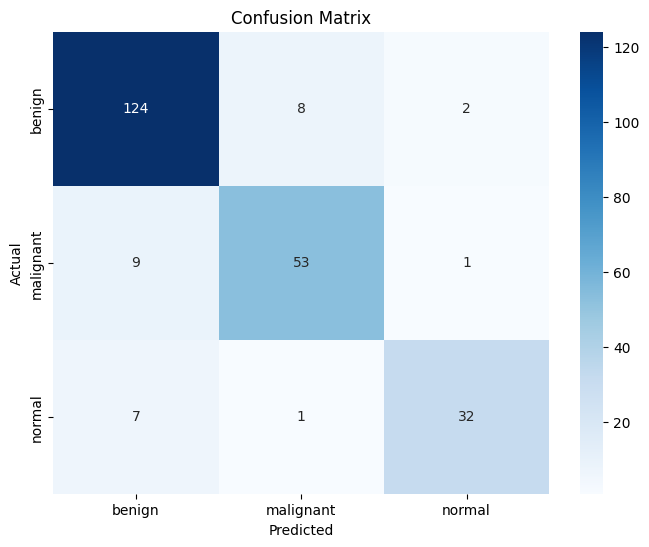

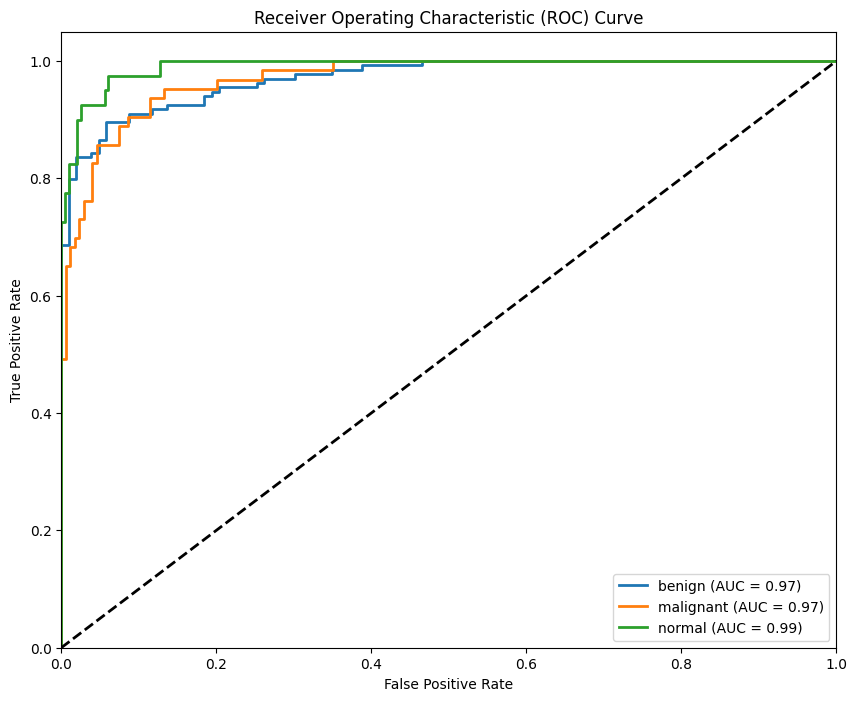

In [ ]:
# Đánh giá mô hình tốt nhất trên tập test
print("\nĐánh giá mô hình tốt nhất trên tập test:")
best_acc, best_precision, best_recall, best_f1, best_cm, best_y_pred_prob = evaluate_model(best_model, X_test, y_test)


In [ ]:
# Lưu mô hình tốt nhất với định dạng khác để sử dụng dễ dàng sau này
model_save_path = '/content/drive/MyDrive/project_01/breast_cancer_model/final_model.keras'
best_model.save(model_save_path)
print(f"Đã lưu mô hình tốt nhất tại {model_save_path}")



Đã lưu mô hình tốt nhất tại /content/drive/MyDrive/project_01/breast_cancer_model/final_model.keras


In [ ]:
# Dự đoán trên dữ liệu mới
def predict_single_image(model, image_path):
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Thêm batch dimension

    # Dự đoán
    prediction = model.predict(img)[0]
    predicted_class = np.argmax(prediction)
    confidence = prediction[predicted_class]

    # Trả về kết quả
    return {
        'class': CLASSES[predicted_class],
        'confidence': confidence,
        'probabilities': {class_name: float(prob) for class_name, prob in zip(CLASSES, prediction)}
    }

In [ ]:
# Hàm để dự đoán trên một thư mục chứa nhiều ảnh
def predict_images_in_folder(model, folder_path):
    results = []

    for img_name in os.listdir(folder_path):
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, img_name)
            result = predict_single_image(model, img_path)
            result['image'] = img_name
            results.append(result)

    return results


Dự đoán ảnh mới:
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
Ảnh: benign (326).png
Dự đoán: benign với độ tin cậy: 0.9996
Xác suất cho các lớp:
  - benign: 0.9996
  - malignant: 0.0004
  - normal: 0.0000


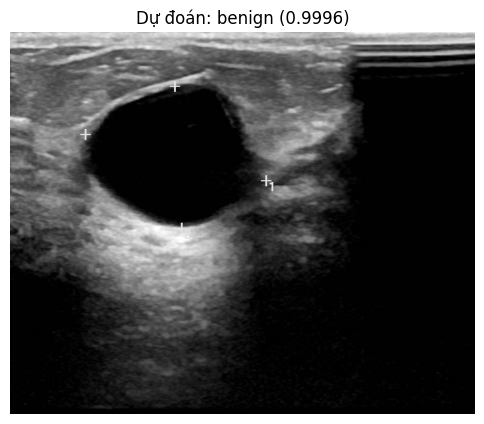

In [ ]:
# Ví dụ dự đoán một ảnh mới (thay đổi đường dẫn theo ảnh thực tế của bạn)
# Giả sử chúng ta sử dụng một ảnh từ tập test
new_image_path = X_test[0]  # Lấy ảnh đầu tiên từ tập test làm ví dụ
print("\nDự đoán ảnh mới:")
prediction_result = predict_single_image(best_model, new_image_path)
print(f"Ảnh: {os.path.basename(new_image_path)}")
print(f"Dự đoán: {prediction_result['class']} với độ tin cậy: {prediction_result['confidence']:.4f}")
print("Xác suất cho các lớp:")
for class_name, prob in prediction_result['probabilities'].items():
    print(f"  - {class_name}: {prob:.4f}")

# Hiển thị ảnh và kết quả dự đoán
img = cv2.imread(new_image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title(f"Dự đoán: {prediction_result['class']} ({prediction_result['confidence']:.4f})")
plt.axis('off')
plt.show()


In [ ]:
# Hàm tiện ích để dự đoán hàng loạt ảnh
def batch_predict(model, image_paths):
    results = []
    for path in image_paths:
        result = predict_single_image(model, path)
        result['image'] = os.path.basename(path)
        results.append(result)

    return results

In [ ]:
# Ví dụ dự đoán một batch nhỏ các ảnh từ tập test
test_sample = X_test[:5]  # Lấy 5 ảnh đầu tiên từ tập test
print("\nDự đoán batch các ảnh mới:")
batch_results = batch_predict(best_model, test_sample)


Dự đoán batch các ảnh mới:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [ ]:
# Hiển thị kết quả
for i, result in enumerate(batch_results):
    actual_class = CLASSES[y_test[i]]
    predicted_class = result['class']
    print(f"Ảnh {i+1}: {result['image']}")
    print(f"  - Lớp thực tế: {actual_class}")
    print(f"  - Dự đoán: {predicted_class} với độ tin cậy: {result['confidence']:.4f}")
    print(f"  - Đúng: {'✓' if actual_class == predicted_class else '✗'}")
    print()



Ảnh 1: benign (326).png
  - Lớp thực tế: benign
  - Dự đoán: benign với độ tin cậy: 0.9996
  - Đúng: ✓

Ảnh 2: benign (281).png
  - Lớp thực tế: benign
  - Dự đoán: benign với độ tin cậy: 0.9333
  - Đúng: ✓

Ảnh 3: malignant (41).png
  - Lớp thực tế: malignant
  - Dự đoán: malignant với độ tin cậy: 0.7823
  - Đúng: ✓

Ảnh 4: malignant (43).png
  - Lớp thực tế: malignant
  - Dự đoán: malignant với độ tin cậy: 0.7687
  - Đúng: ✓

Ảnh 5: malignant (88)_mask.png
  - Lớp thực tế: malignant
  - Dự đoán: malignant với độ tin cậy: 0.9994
  - Đúng: ✓



In [ ]:
# Hiển thị một bảng tổng kết kết quả phân loại
print("\nTổng kết hiệu năng mô hình:")
print(f"Accuracy: {best_acc:.4f}")
print(f"Macro Precision: {np.mean(best_precision):.4f}")
print(f"Macro Recall: {np.mean(best_recall):.4f}")
print(f"Macro F1-Score: {np.mean(best_f1):.4f}")


Tổng kết hiệu năng mô hình:
Accuracy: 0.8819
Macro Precision: 0.8849
Macro Recall: 0.8555
Macro F1-Score: 0.8688
